In [1]:
import numpy as np

import pandas as pd

# used to grab the stock prices, with yahoo

import pandas_datareader as web

from datetime import datetime
from dateutil.relativedelta import relativedelta

# to visualize the results

import matplotlib.pyplot as plt

import seaborn

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import os
import re
from time import sleep

In [3]:
# STEP 1: Load stock screener data from nasdaq.
# The stock screener is a csv file downloaded from the nasdaq website and contains information (Symbol, market cap,
# sectors, industries and more) about different stocks.



chromeOptions = webdriver.ChromeOptions()
cur_dir = os.getcwd()
prefs = {"download.default_directory" : cur_dir}
chromeOptions.add_experimental_option("prefs",prefs)

driver = webdriver.Chrome(executable_path=ChromeDriverManager().install(), chrome_options=chromeOptions)
driver.get("https://www.nasdaq.com/market-activity/stocks/screener")

driver.implicitly_wait(5)
link = driver.find_element_by_class_name("nasdaq-screener__download")
link.click()


file_location = os.path.join(cur_dir, 'nasdaq_screener.csv')

if os.path.isfile(file_location):
    os.remove(file_location) # delete if previous file exists

# delete suffix from the csv file's name
file_regex = re.compile('nasdaq_screener_\d+\.csv')

sleep(15)

while not os.path.isfile(file_location):
    for root, dirs, files in os.walk(cur_dir):
        for f in files:
            if file_regex.match(f):
                os.rename(f, 'nasdaq_screener.csv')
                break


driver.close()



====== WebDriver manager ======
Current google-chrome version is 98.0.4758
Get LATEST chromedriver version for 98.0.4758 google-chrome
Driver [/Users/nadavsmacbookpro/.wdm/drivers/chromedriver/mac64/98.0.4758.80/chromedriver] found in cache
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: use options instead of chrome_options
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # This is added back by InteractiveShellApp.init_path()


In [4]:
# Get tickers from csv to pandas

stocks_screener = pd.read_csv('nasdaq_screener.csv')
stocks_screener = stocks_screener.sort_values(by='Market Cap', ascending=False)


In [5]:
sectors_set = set(stocks_screener["Sector"])
sectors_dict = {sector: list(stocks_screener.loc[stocks_screener["Sector"] == sector]["Symbol"][:10]) for sector in sectors_set}

In [6]:
seaborn.set(rc={"figure.dpi":300, 'savefig.dpi':300})

# select start date for correlation window as well as list of tickers

start = datetime.today() + relativedelta(months=-12)

# symbols_list = list(stocks_screener['Symbol'][:50])
# symbols= dict()

In [7]:
# pull price using iex for each symbol in list defined above
sectors_df = {sector: list() for sector in sectors_set}
for key, value in sectors_dict.items():
    print(f"######### {key} #########\n")
    if len(value) == 0:
        continue
    dates = set()
    for ticker in value:
        print(ticker)
        r = web.DataReader(ticker, 'yahoo', start)

        if len(dates) == 0:
            dates = set(r.index)
        else:
            dates = dates.intersection(set(r.index))

        # add a symbol column
        r['Symbol'] = ticker
        r['Industry'] = list(stocks_screener.loc[stocks_screener["Symbol"] == ticker]['Industry'])[0]

        sectors_df[key].append(r)
    sectors_df[key] = pd.concat(sectors_df[key])
    sectors_df[key] = sectors_df[key].loc[list(dates)]


# sectors_df

######### Consumer Services #########

AMZN
WMT
HD
BABA
DIS
COST
CMCSA
MCD
NFLX
T
######### nan #########

######### Capital Goods #########

TSLA
TM
TMO
RTX
BA
AMAT
DE
CAT
LMT
GM
######### Miscellaneous #########

V
MA
NTES
ACN
PYPL
JD
BAM
ADP
PDD
FIS
######### Basic Industries #########

BHP
LIN
RIO
VALE
SHW
FCX
APD
SCCO
NEM
DOW
######### Technology #########

AAPL
MSFT
GOOG
GOOGL
NVDA
TSM
FB
ASML
AVGO
ADBE
######### Transportation #########

UPS
UNP
BKNG
ABNB
CSX
NSC
FDX
ODFL
EXPE
DAL
######### Energy #########

XOM
CVX
TTE
COP
BP
EQNR
PTR
PBR
ENB
SHEL
######### Health Care #########

UNH
JNJ
PFE
ABBV
NVO
LLY
ABT
DHR
NVS
MRK
######### Public Utilities #########

VZ
TMUS
NEE
DUK
SO
D
WM
AMX
AMOV
EXC
######### Consumer Non-Durables #########

PG
KO
PEP
NKE
PM
SONY
UL
DEO
EL
BUD
######### Consumer Durables #########

GE
ABB
FERG
AME
BLL
VTRS
GNRC
CLX
CCK
PLUG
######### Finance #########

JPM
BAC
WFC
MS
SCHW
HSBC
AXP
C
HDB
GS


In [10]:
sectors_df['Basic Industries']

,High,Low,Open,Close,Volume,Adj Close,Symbol,Industry
Date,,,,,,,,
2021-05-05,77.400002,75.870003,76.129997,77.199997,1899900.0,77.199997,BHP,Precious Metals
2021-05-05,292.769989,286.739990,287.589996,291.609985,1763500.0,288.641541,LIN,Major Chemicals
2021-05-05,90.959999,88.320000,88.470001,90.379997,3730100.0,84.491127,RIO,Steel/Iron Ore
2021-05-05,21.000000,20.629999,20.870001,20.730000,26637300.0,18.403008,VALE,Steel/Iron Ore
2021-05-05,285.260010,280.450012,284.839996,283.279999,1059200.0,281.743774,SHW,Paints/Coatings
...,...,...,...,...,...,...,...,...
2021-10-07,34.490002,32.619999,32.750000,34.320000,37035100.0,34.134357,FCX,Precious Metals
2021-10-07,266.529999,262.040009,262.369995,263.350006,1359600.0,262.050110,APD,Specialty Chemicals
2021-10-07,58.959999,57.349998,57.349998,58.310001,1057300.0,57.366474,SCCO,Precious Metals


In [15]:
from collections import OrderedDict
dataframes = {sector: None for sector in sectors_set}
# concatenate into df
counter = 0
x = None
for sector in sectors_set:
    if len(sectors_df[sector]) == 0:
        continue

    df = sectors_df[sector].sort_values(by='Industry')
    order = list(OrderedDict.fromkeys(df['Symbol'].tolist()))

    df = df.reset_index()

    df = df[['Date', 'Close', 'Symbol']]

    df_pivot = df.pivot(index='Date', columns='Symbol', values='Close')

    # df_pivot.head()

    dataframes[sector] = df_pivot

# dataframes[sector]
dataframes['Basic Industries']


Symbol,APD,BHP,DOW,FCX,LIN,NEM,RIO,SCCO,SHW,VALE
Date,,,,,,,,,,
2021-02-10,253.580002,69.809998,57.669998,31.240000,252.720001,59.700001,83.059998,71.500000,237.440002,17.650000
2021-02-11,257.690002,69.720001,57.669998,30.990000,253.110001,58.380001,82.279999,70.650002,239.763336,17.370001
2021-02-12,260.549988,70.379997,58.150002,31.230000,252.679993,58.939999,83.660004,72.459999,240.350006,17.500000
2021-02-16,260.730011,75.480003,58.750000,32.900002,250.139999,57.799999,87.629997,73.019997,235.806671,18.030001
2021-02-17,260.010010,75.570000,58.540001,34.150002,249.279999,56.990002,87.540001,74.330002,240.466660,17.870001
...,...,...,...,...,...,...,...,...,...,...
2022-02-04,263.079987,66.160004,60.599998,38.419998,297.980011,60.930000,73.889999,63.209999,281.730011,16.549999
2022-02-07,254.380005,68.449997,59.910000,38.900002,296.470001,63.369999,76.639999,63.669998,279.220001,17.170000
2022-02-08,252.809998,69.160004,61.090000,40.630001,298.709991,63.560001,78.099998,65.620003,279.670013,17.430000


In [15]:
corr_df = df_pivot.corr(method='pearson')

# reset symbol as index (rather than 0-X)

corr_df.head().reset_index()

#del corr_df.index.name

corr_df.head(10)
# corr_df = corr_df.reindex(corr_df.mean().sort_values().index, axis = 0)

Symbol,AMZN,CMCSA,COST,DIS,HD,LOW,MCD,NFLX,T,WMT
Symbol,,,,,,,,,,
AMZN,1.000000,0.256670,0.319003,-0.009009,0.357584,0.281588,0.290887,0.552914,-0.237009,0.346144
CMCSA,0.256670,1.000000,-0.320598,0.604068,-0.292489,-0.367702,-0.185069,-0.117848,0.460176,0.018879
COST,0.319003,-0.320598,1.000000,-0.797290,0.936654,0.931314,0.911128,0.494747,-0.878580,0.435066
DIS,-0.009009,0.604068,-0.797290,1.000000,-0.760835,-0.773383,-0.720780,-0.099372,0.750873,-0.205569
HD,0.357584,-0.292489,0.936654,-0.760835,1.000000,0.983710,0.939911,0.461158,-0.762812,0.308077
LOW,0.281588,-0.367702,0.931314,-0.773383,0.983710,1.000000,0.934324,0.455708,-0.775816,0.284243
MCD,0.290887,-0.185069,0.911128,-0.720780,0.939911,0.934324,1.000000,0.322095,-0.702218,0.272713
NFLX,0.552914,-0.117848,0.494747,-0.099372,0.461158,0.455708,0.322095,1.000000,-0.546438,0.348519
T,-0.237009,0.460176,-0.878580,0.750873,-0.762812,-0.775816,-0.702218,-0.546438,1.000000,-0.284295


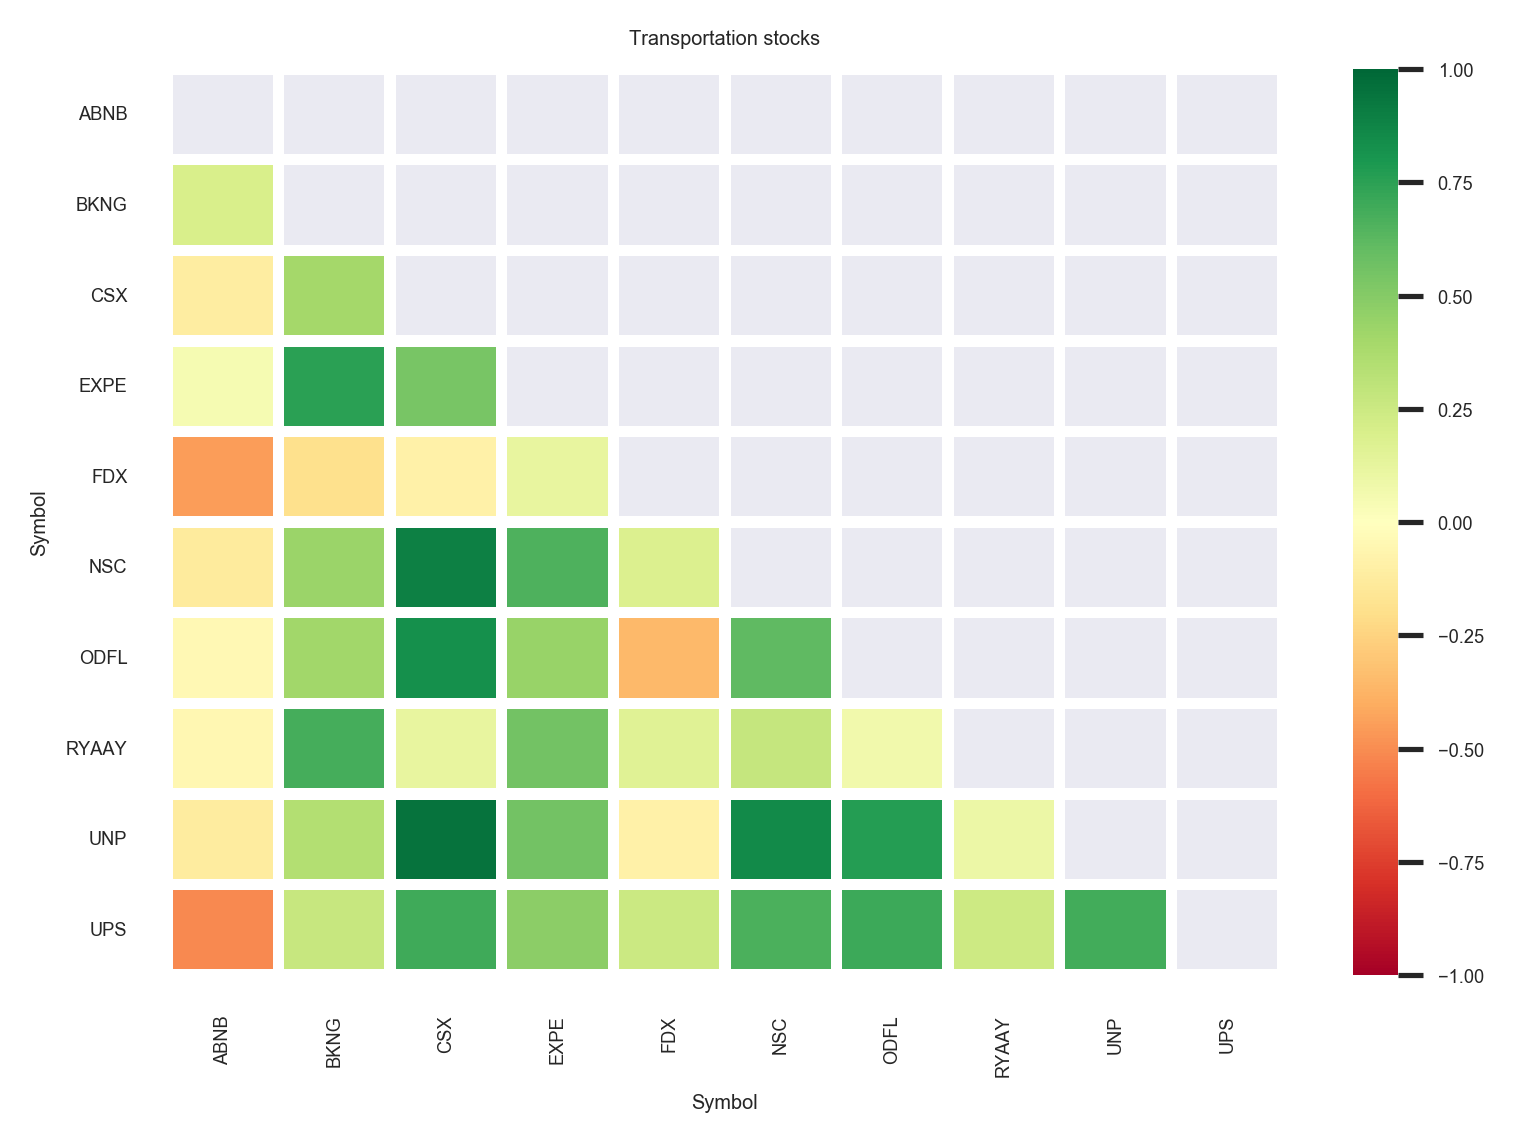

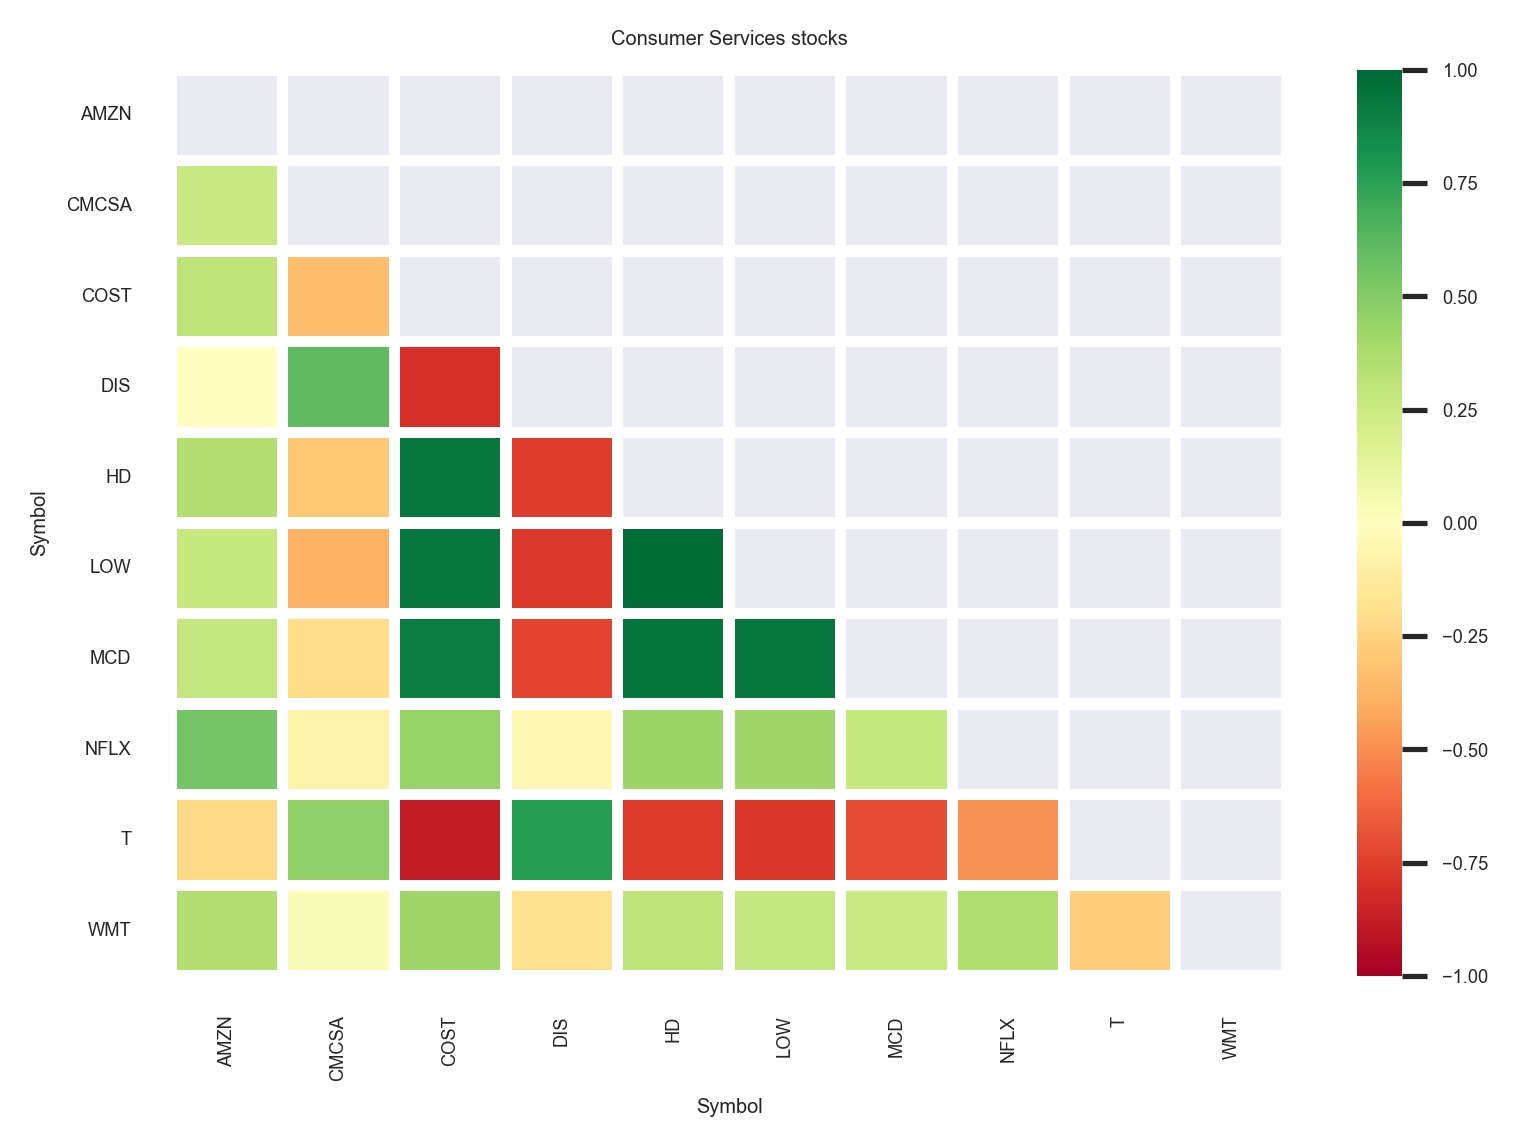

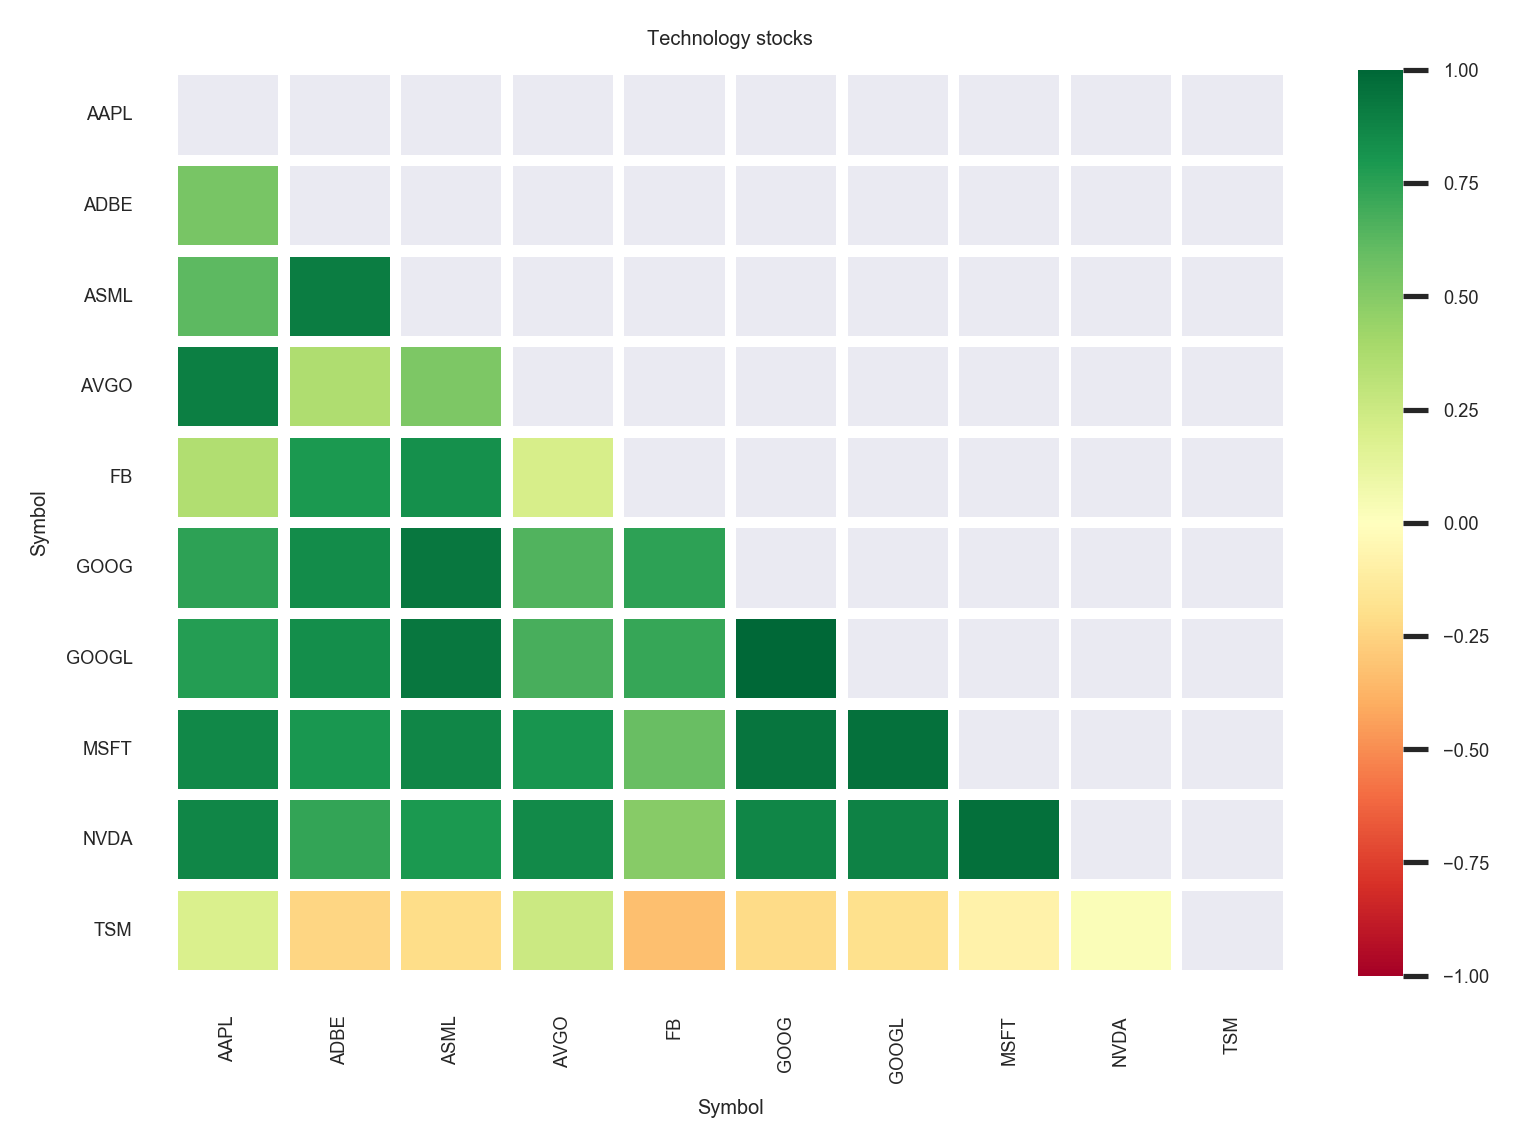

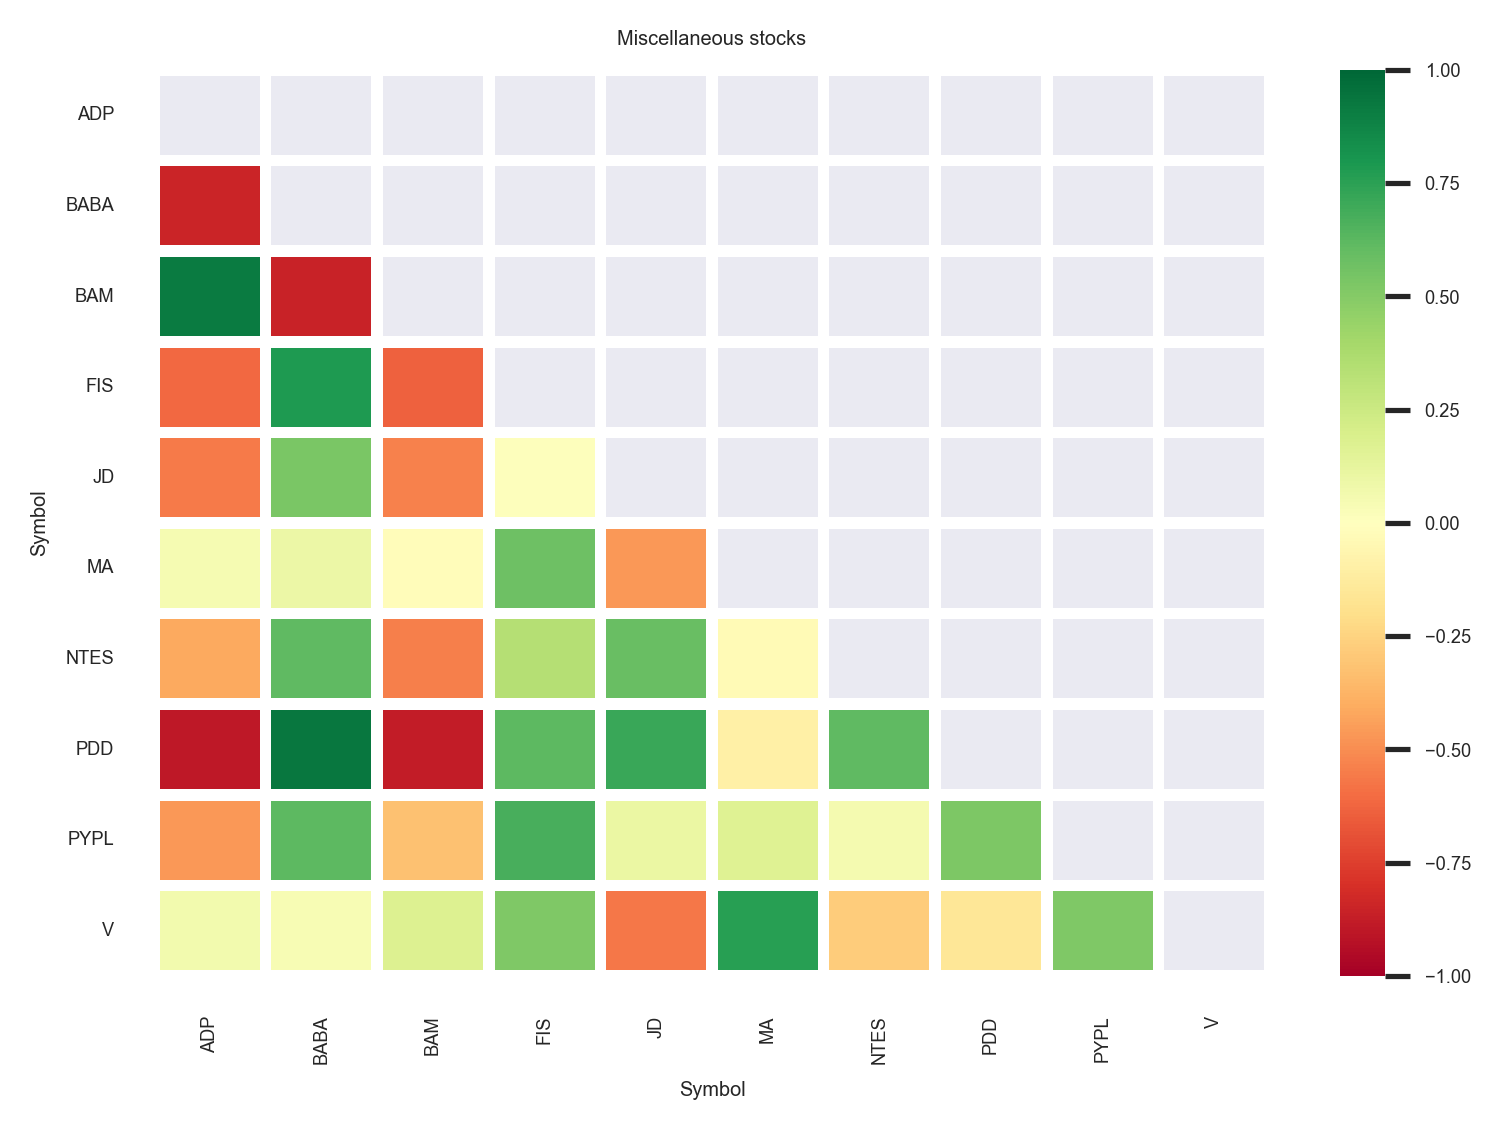

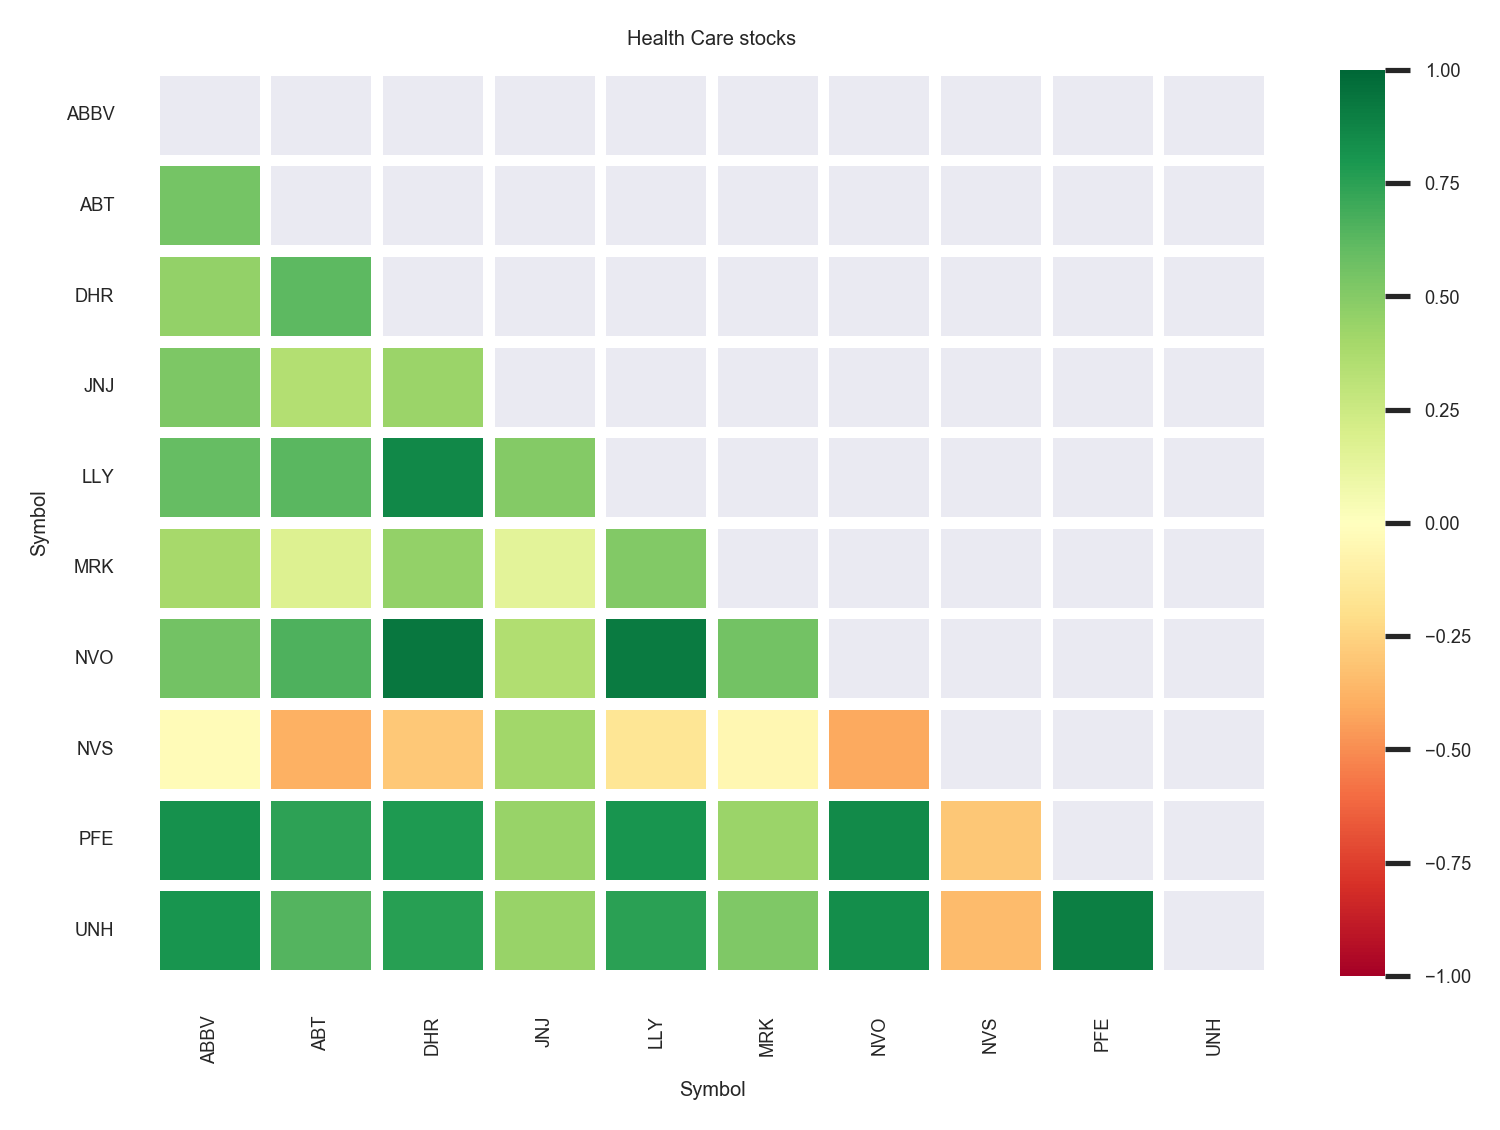

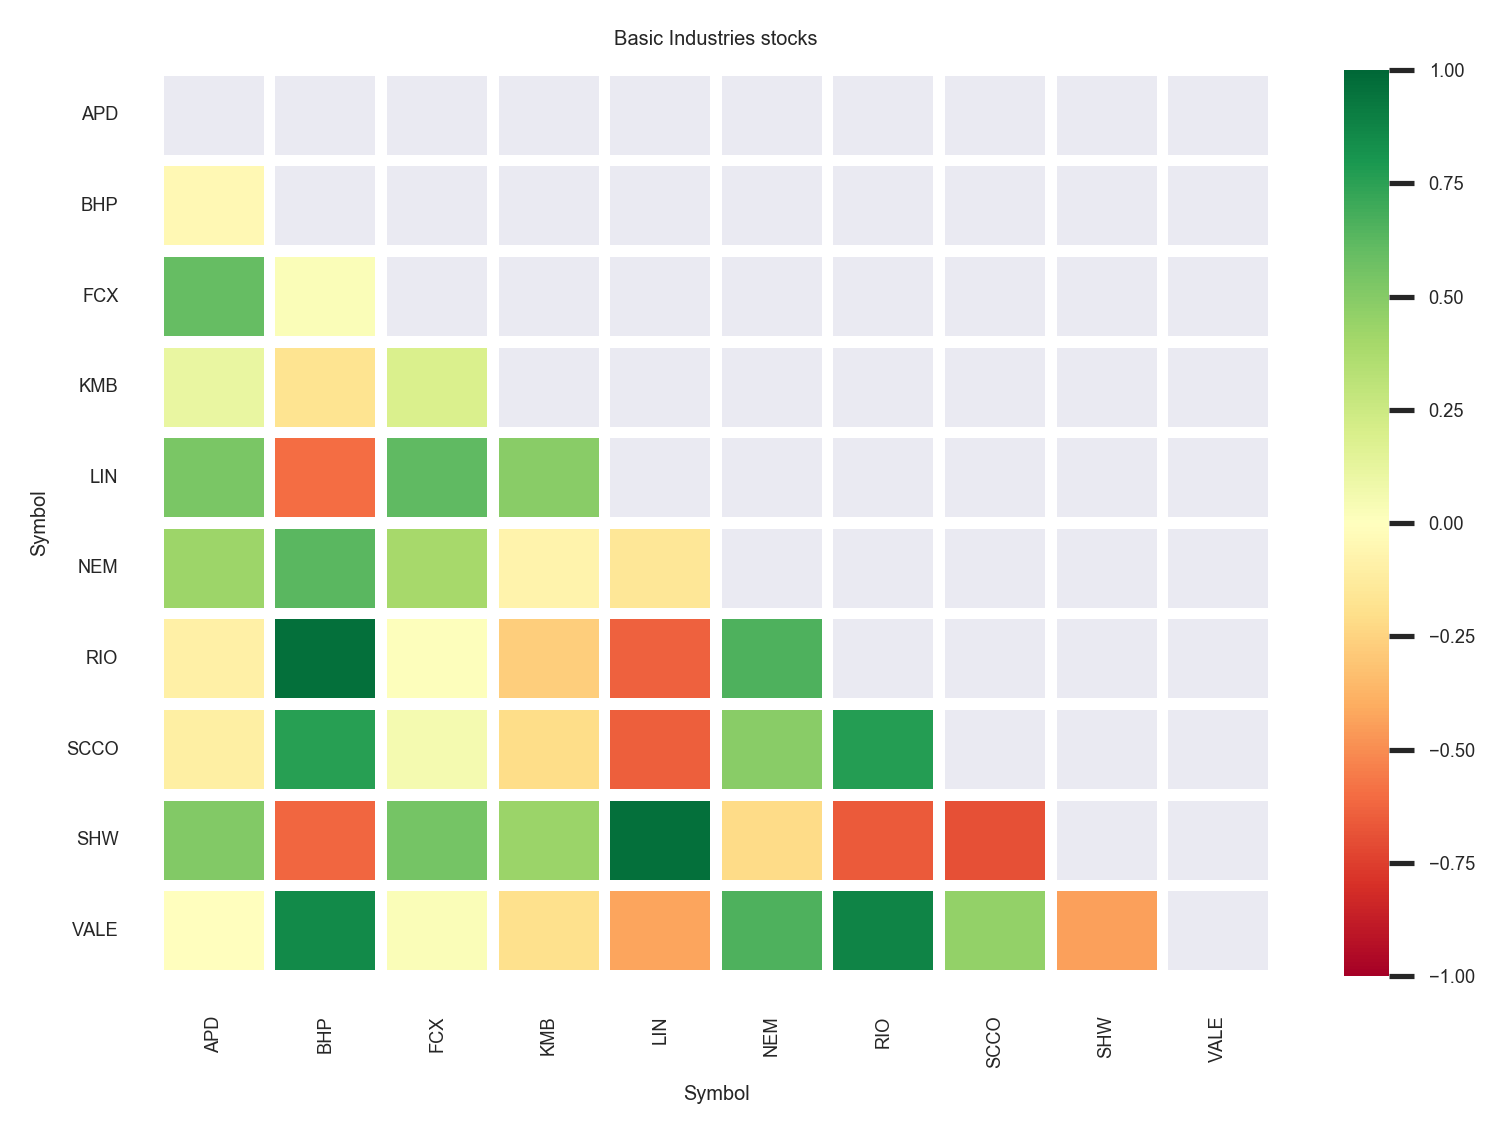

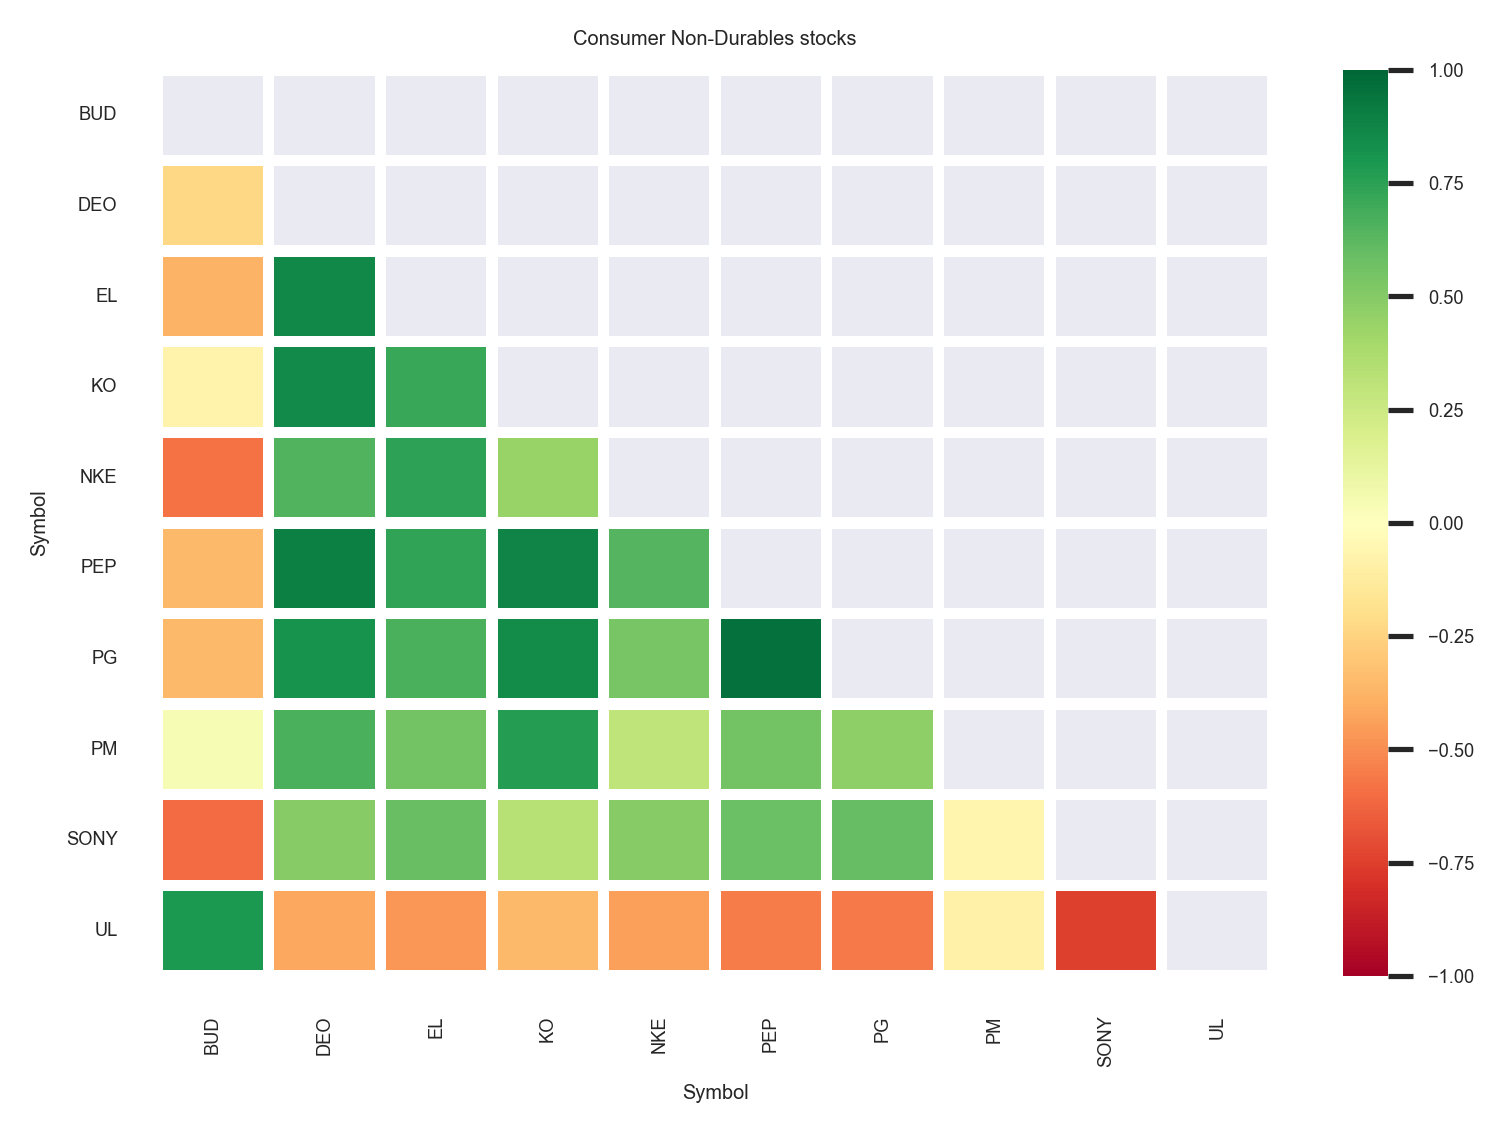

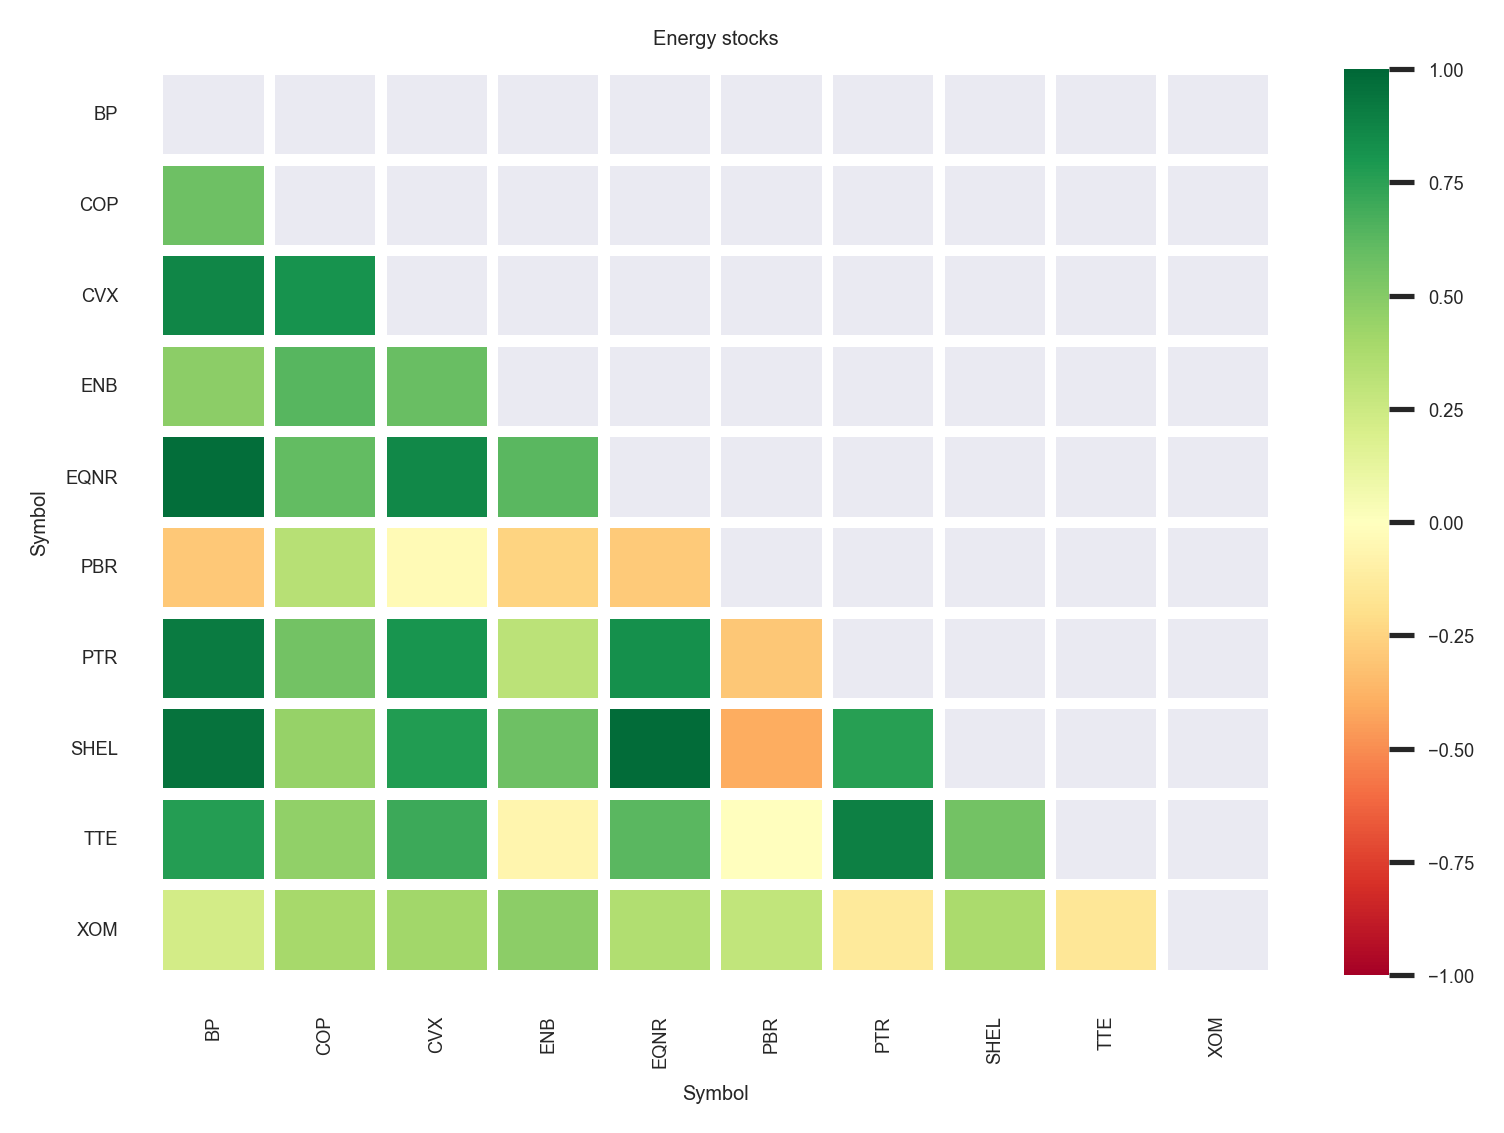

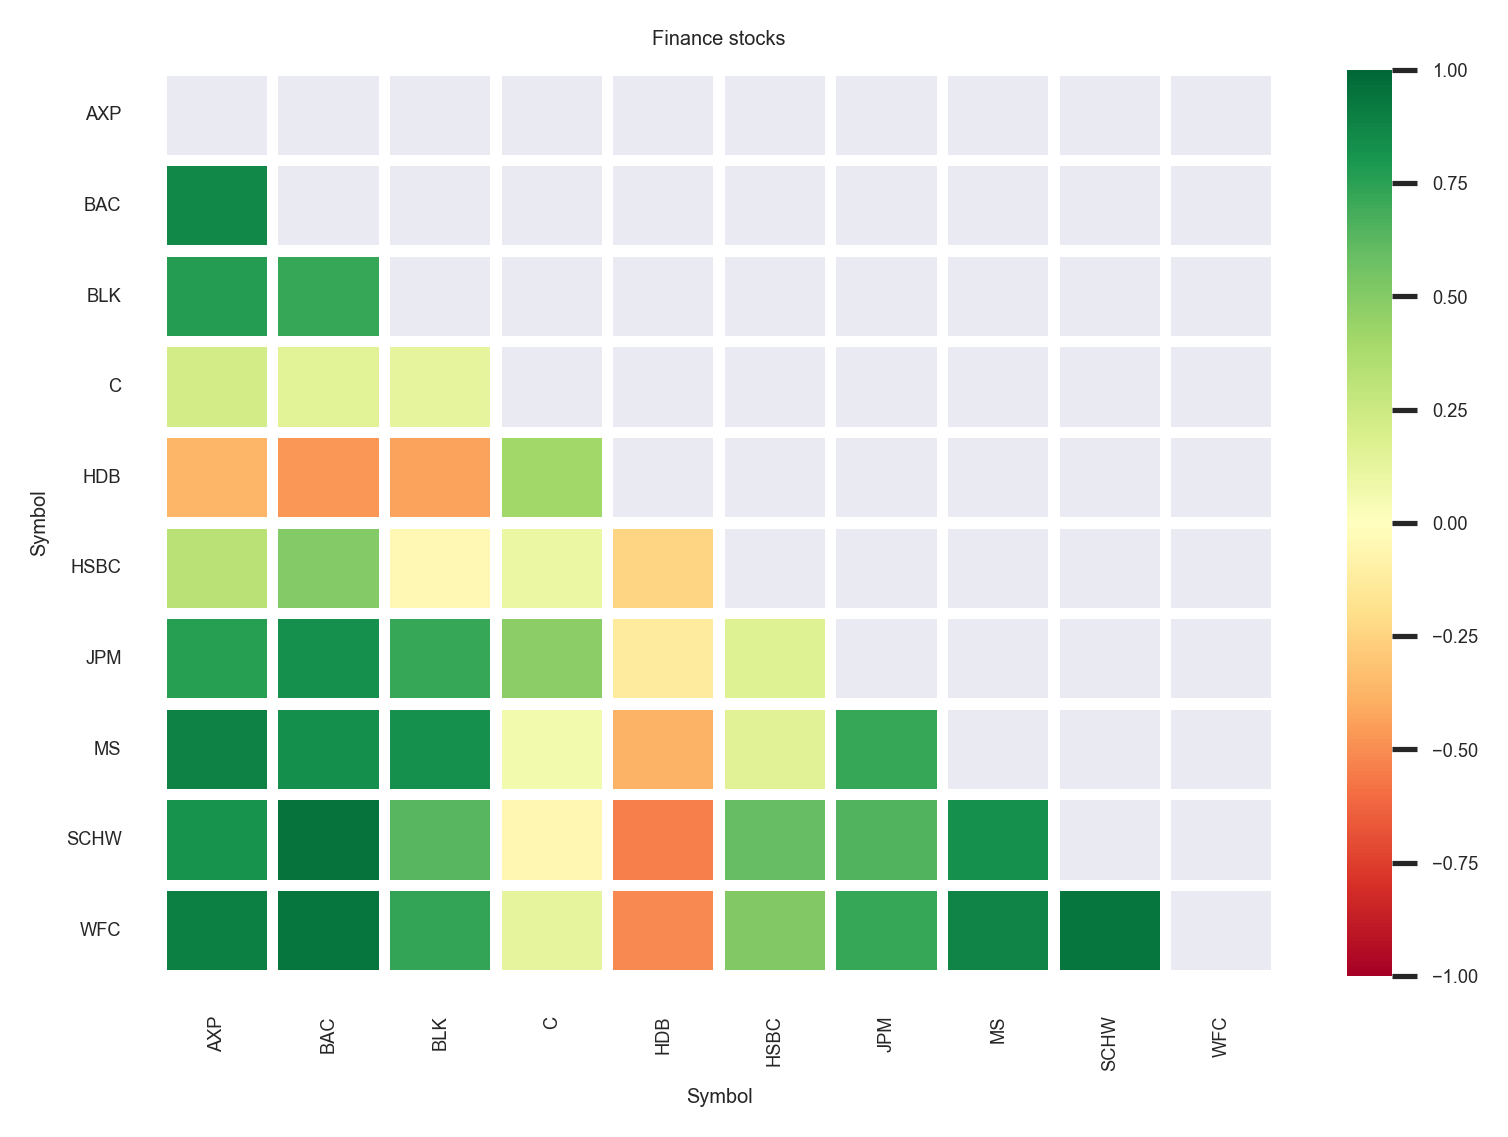

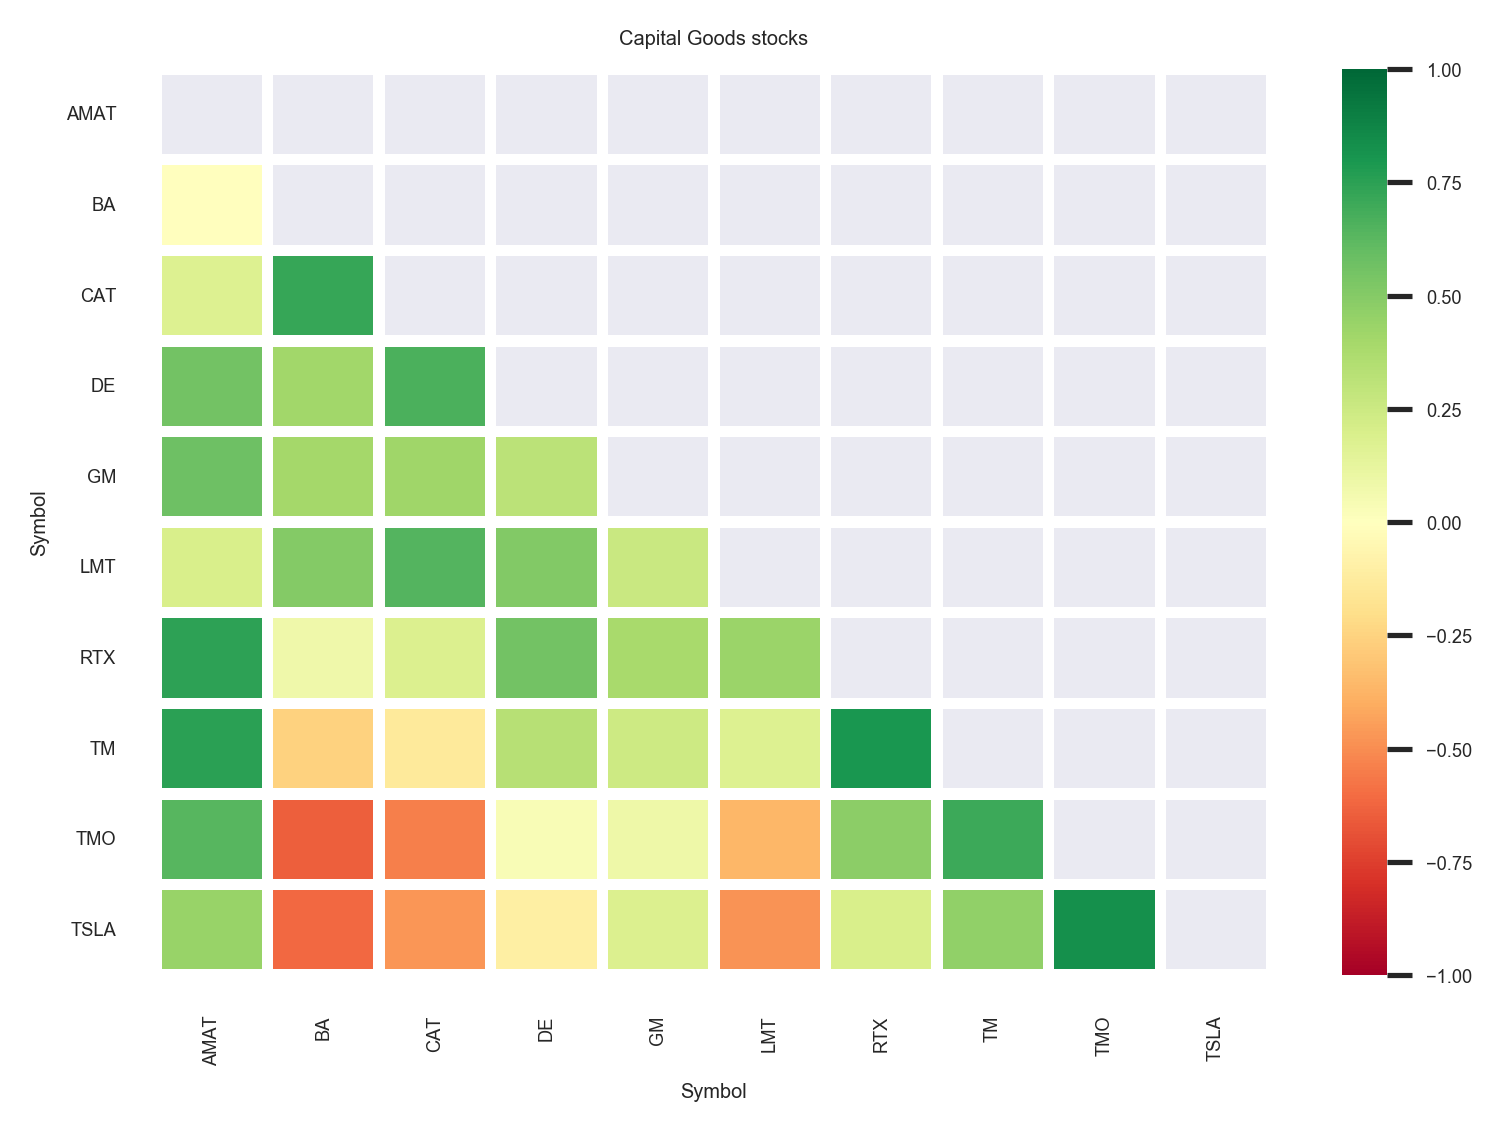

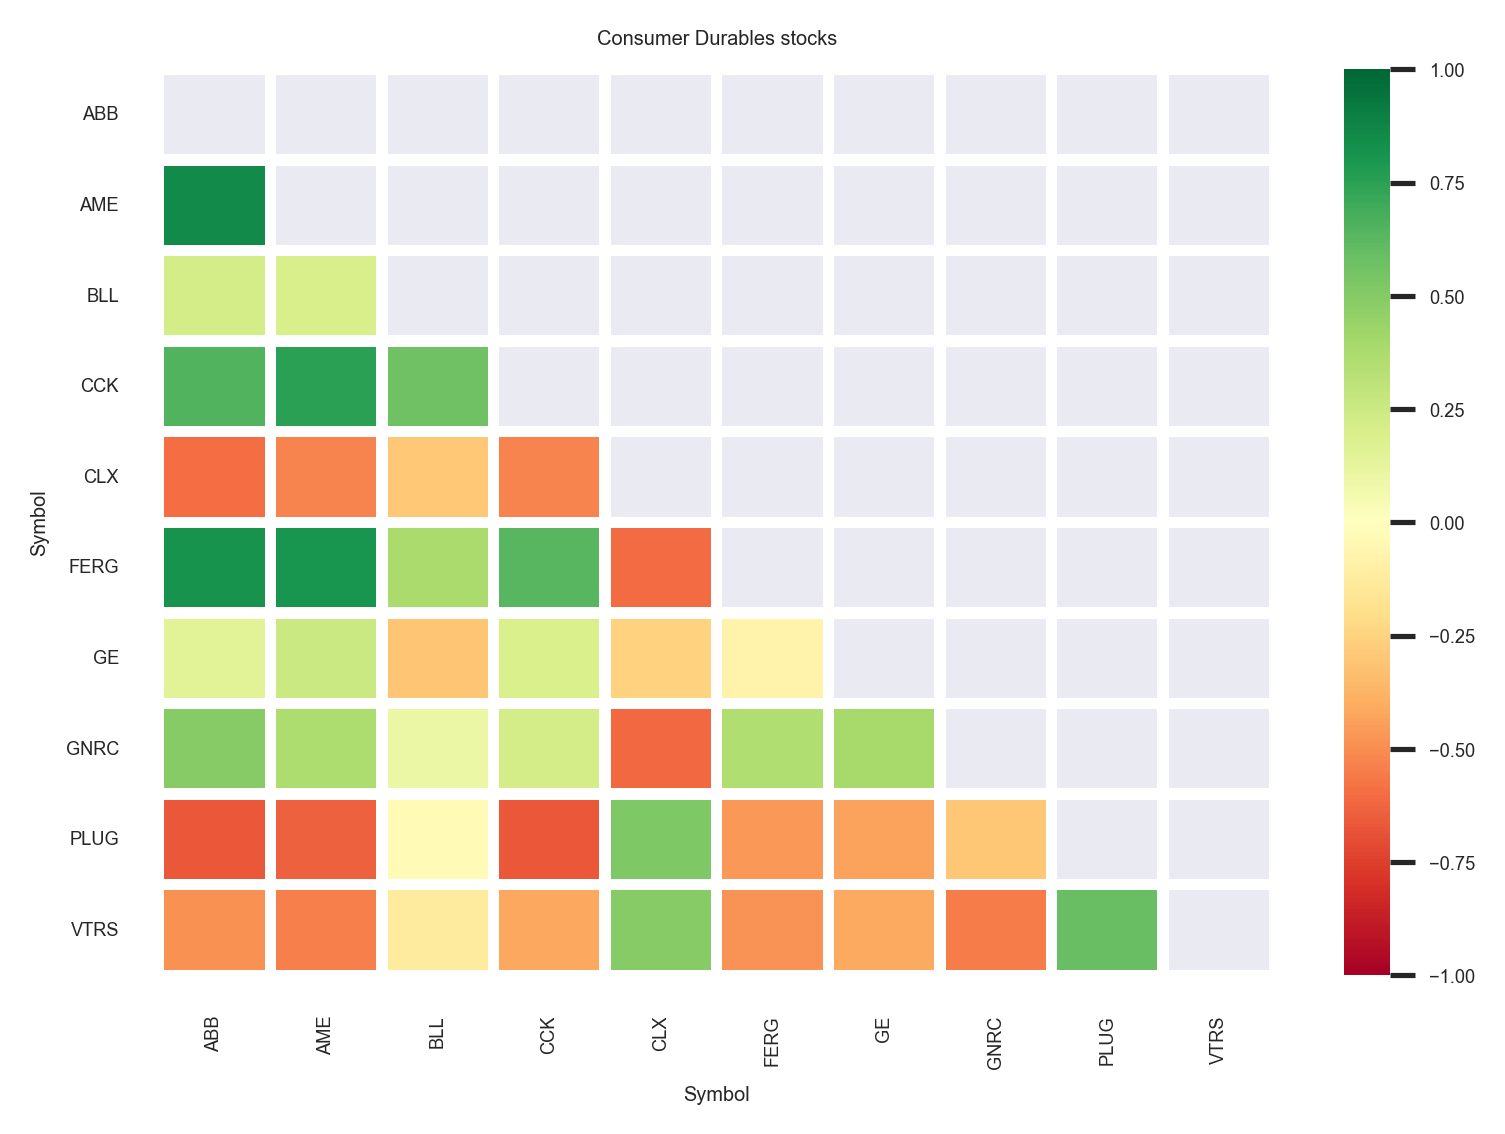

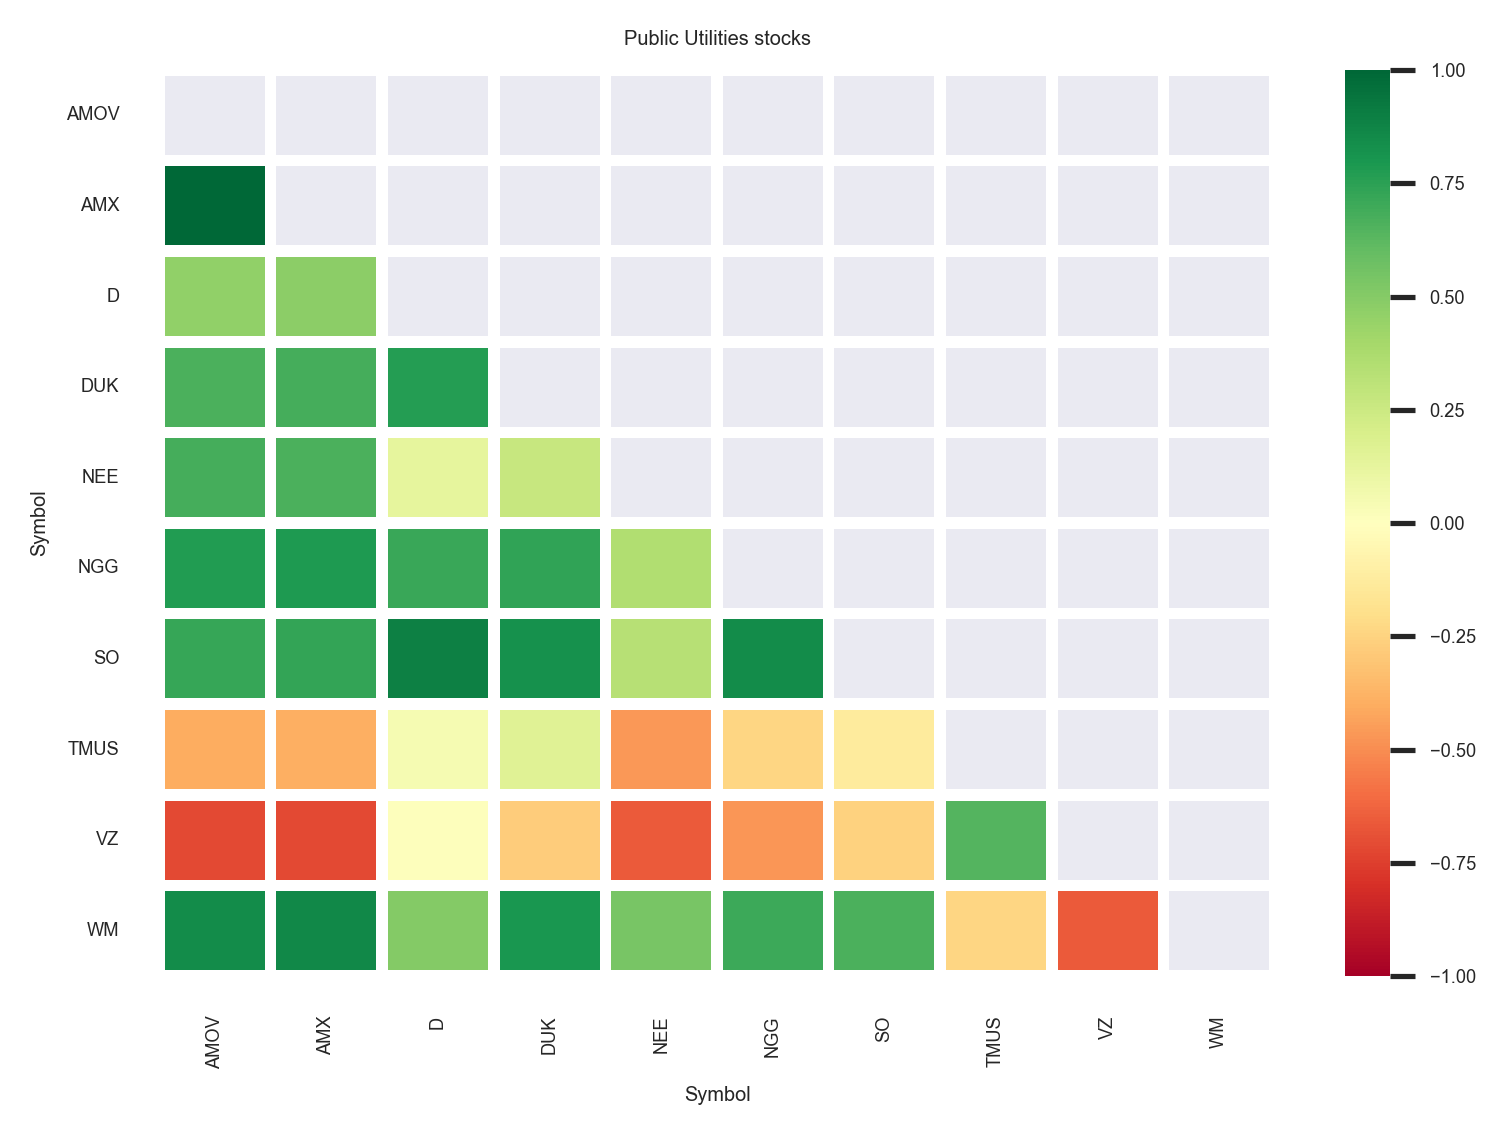

In [8]:
# take the bottom triangle since it repeats itself
counter = 0
for sector in sectors_set:
    if counter == 0:
        counter += 1
        continue
    data = dataframes[sector].corr(method='pearson')
    mask = np.zeros_like(data)

    mask[np.triu_indices_from(mask)] = True

    # generate plot
    seaborn.set(font_scale=0.4)

    seaborn.heatmap(data, cmap='RdYlGn', vmax=1.0, vmin=-1.0, mask=mask, linewidths=2.5)
    plt.title(f"{sector} stocks")

    plt.yticks(rotation=0)

    plt.xticks(rotation=90)
    plt.savefig(f"{sector}.png")
    plt.show()

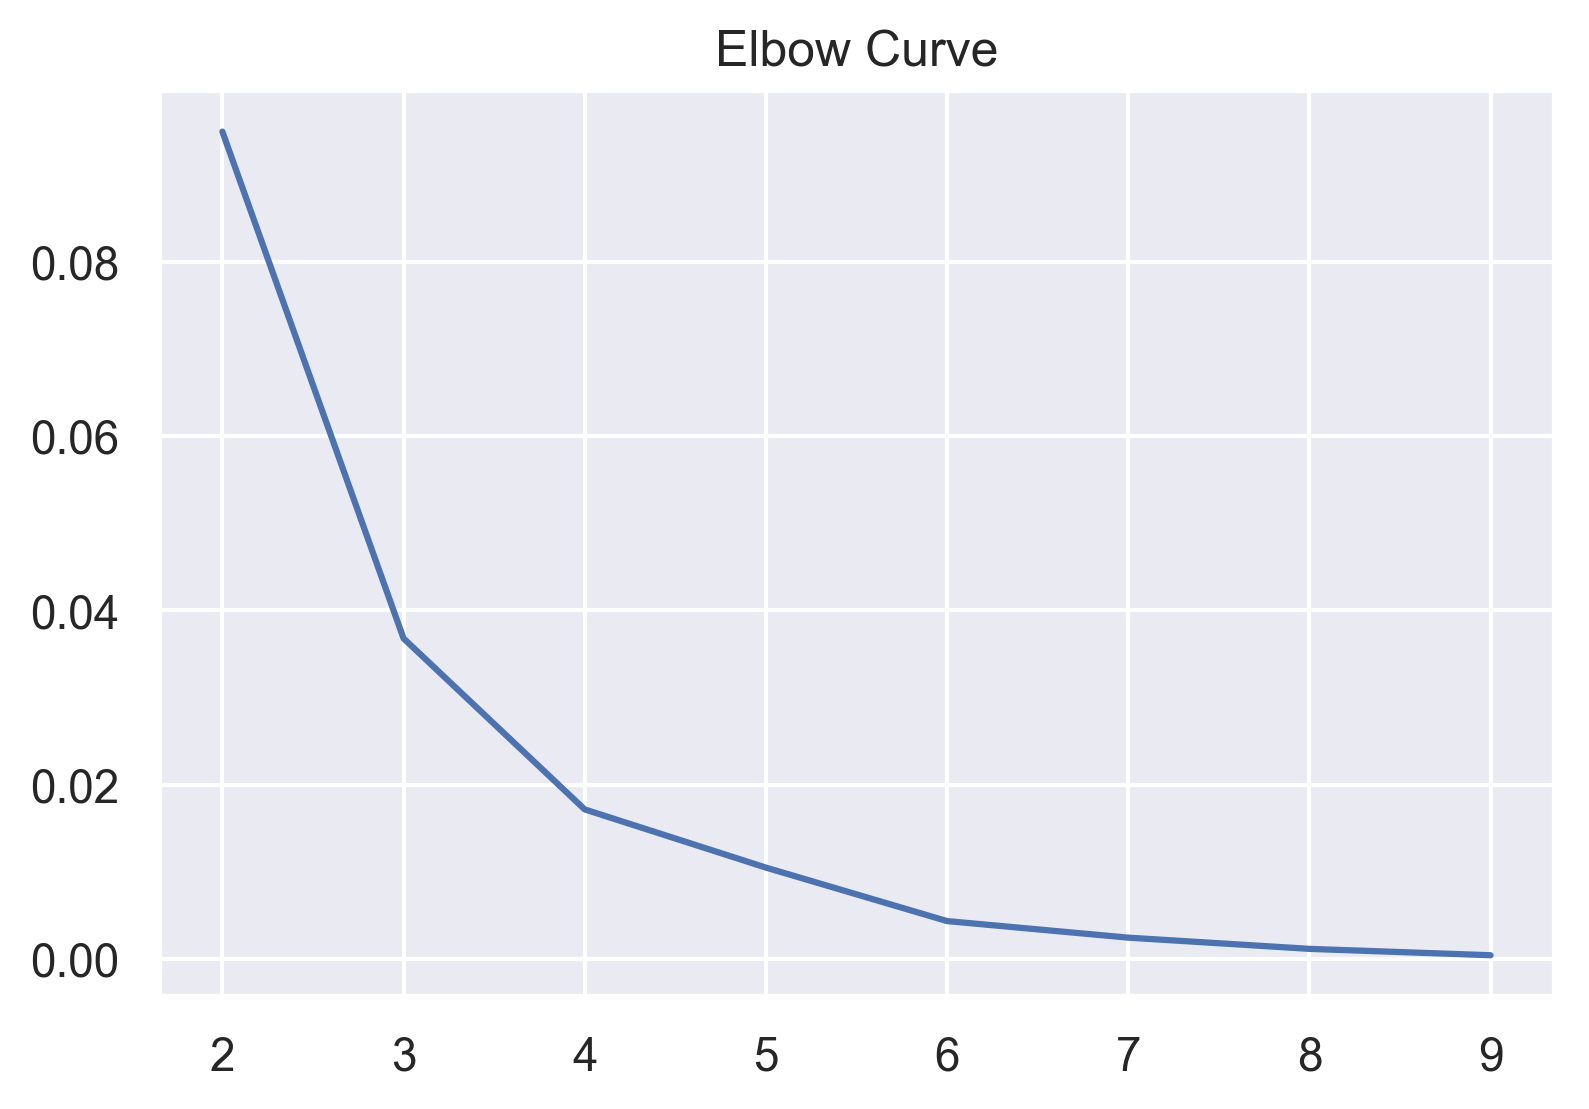

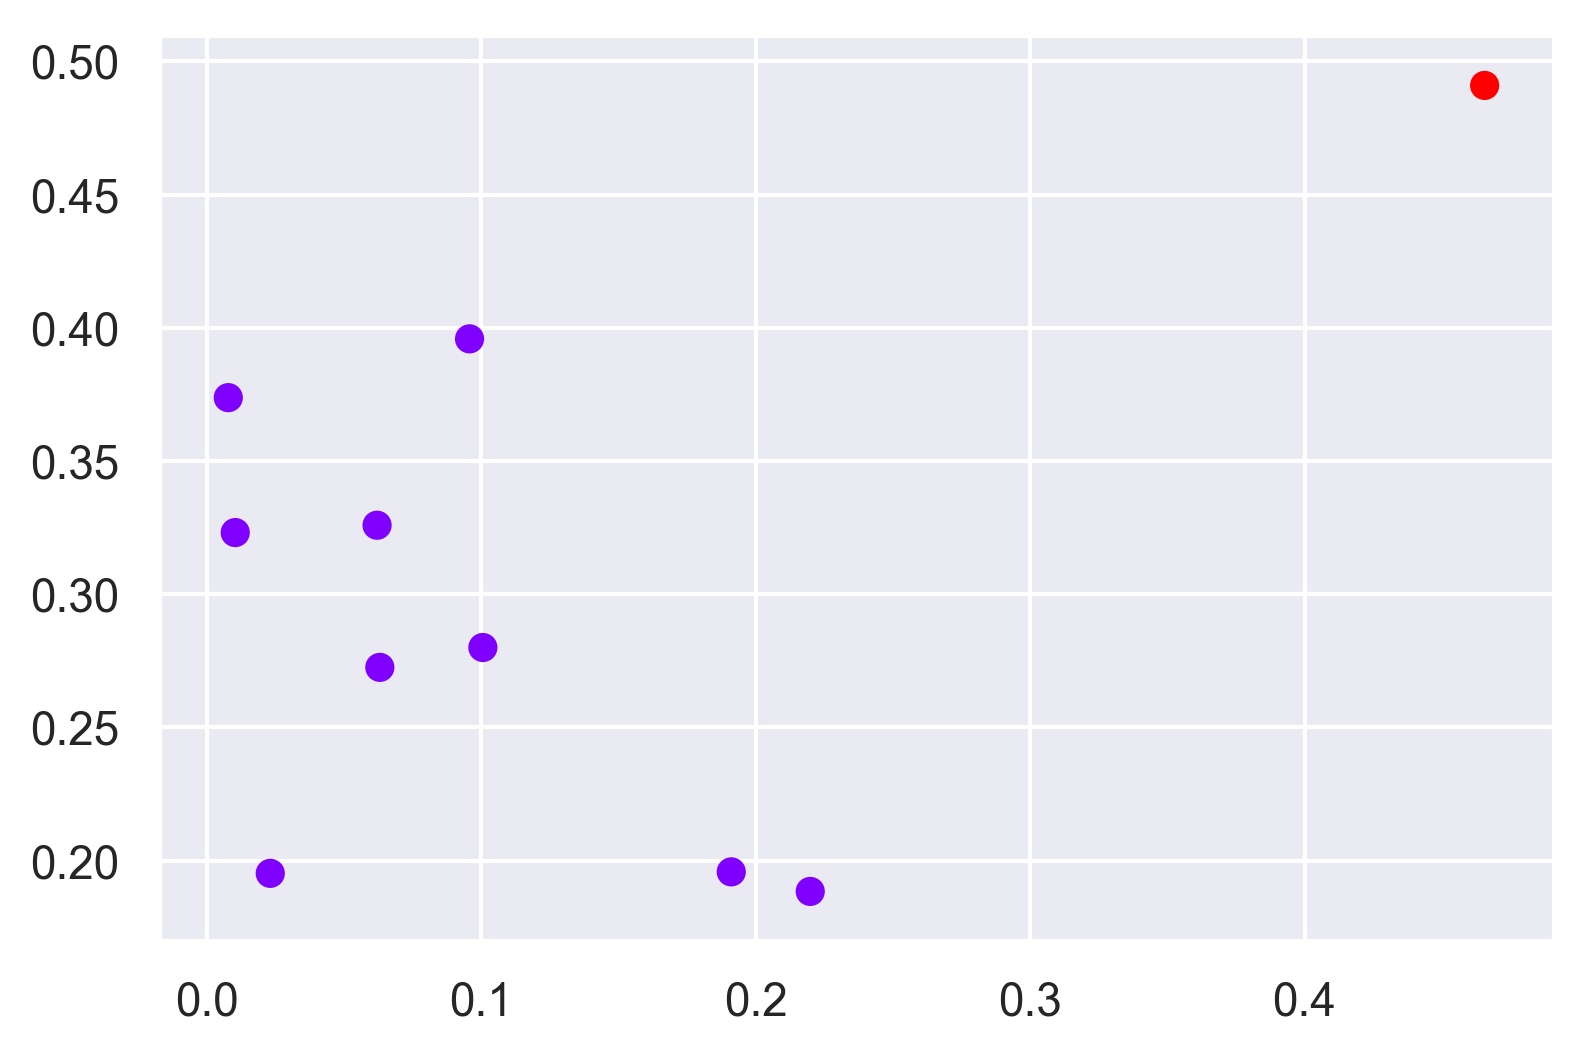

In [16]:
import pandas as pd
from sklearn.cluster import KMeans
from math import sqrt
import  pylab as pl
import numpy as np


data = dataframes['Basic Industries']
returns = data.pct_change().mean() * 252
variance = data.pct_change().std() * np.sqrt(252)
returns.columns = ["Returns"]
variance.columns = ["Variance"]
#Concatenating the returns and variances into a single data-frame
ret_var = pd.concat([returns, variance], axis = 1).dropna()
ret_var.columns = ["Returns","Variance"]
X =  ret_var.values #Converting ret_var into nummpy array
sse = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)

    sse.append(kmeans.inertia_) #SSE for each n_clusters
pl.plot(range(2,10), sse)
pl.title("Elbow Curve")
pl.show()

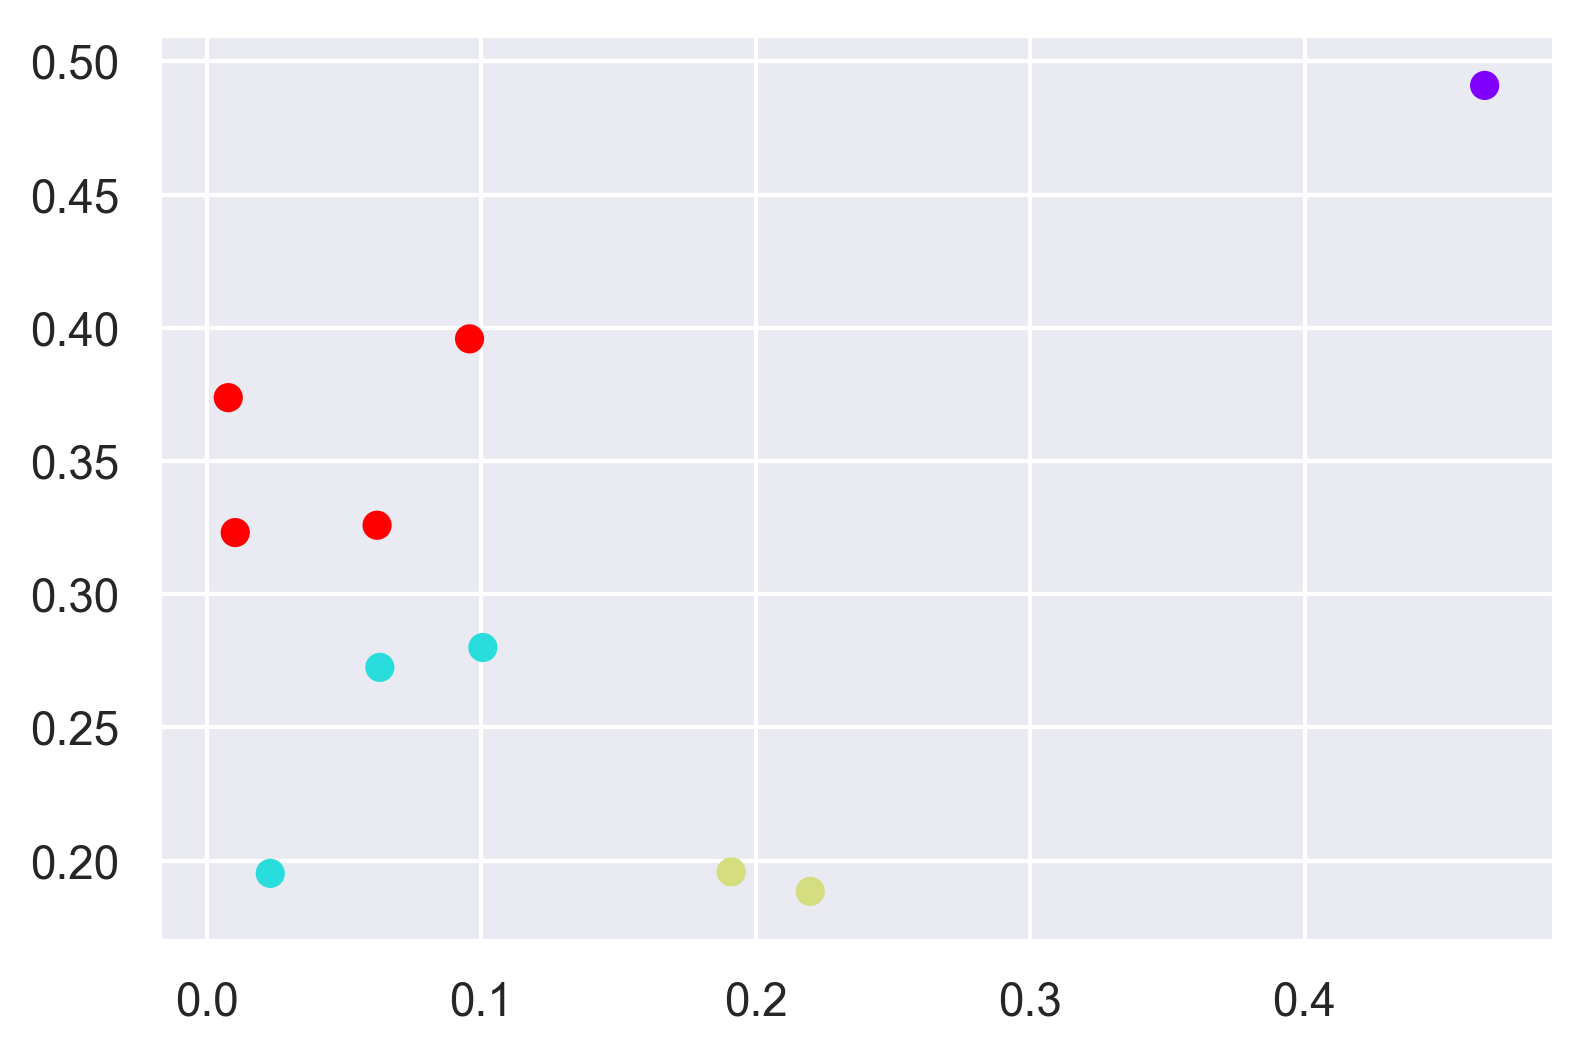

,0
0,Date
1,Close
2,Symbol


In [26]:
K = 4

kmeans = KMeans(n_clusters = K).fit(X)
centroids = kmeans.cluster_centers_
pl.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
pl.show()

In [39]:
data

Symbol,APD,BHP,DOW,FCX,LIN,NEM,RIO,SCCO,SHW,VALE
Date,,,,,,,,,,
2021-02-10,253.580002,69.809998,57.669998,31.240000,252.720001,59.700001,83.059998,71.500000,237.440002,17.650000
2021-02-11,257.690002,69.720001,57.669998,30.990000,253.110001,58.380001,82.279999,70.650002,239.763336,17.370001
2021-02-12,260.549988,70.379997,58.150002,31.230000,252.679993,58.939999,83.660004,72.459999,240.350006,17.500000
2021-02-16,260.730011,75.480003,58.750000,32.900002,250.139999,57.799999,87.629997,73.019997,235.806671,18.030001
2021-02-17,260.010010,75.570000,58.540001,34.150002,249.279999,56.990002,87.540001,74.330002,240.466660,17.870001
...,...,...,...,...,...,...,...,...,...,...
2022-02-04,263.079987,66.160004,60.599998,38.419998,297.980011,60.930000,73.889999,63.209999,281.730011,16.549999
2022-02-07,254.380005,68.449997,59.910000,38.900002,296.470001,63.369999,76.639999,63.669998,279.220001,17.170000
2022-02-08,252.809998,69.160004,61.090000,40.630001,298.709991,63.560001,78.099998,65.620003,279.670013,17.430000


Symbol
FCX    141.581306
dtype: float64
Symbol
APD    100.414072
DOW    106.381135
NEM    102.680064
dtype: float64
Symbol
LIN    122.499203
SHW    118.848974
dtype: float64
Symbol
BHP     100.902457
RIO      95.870455
SCCO     93.993010
VALE    101.784706
dtype: float64


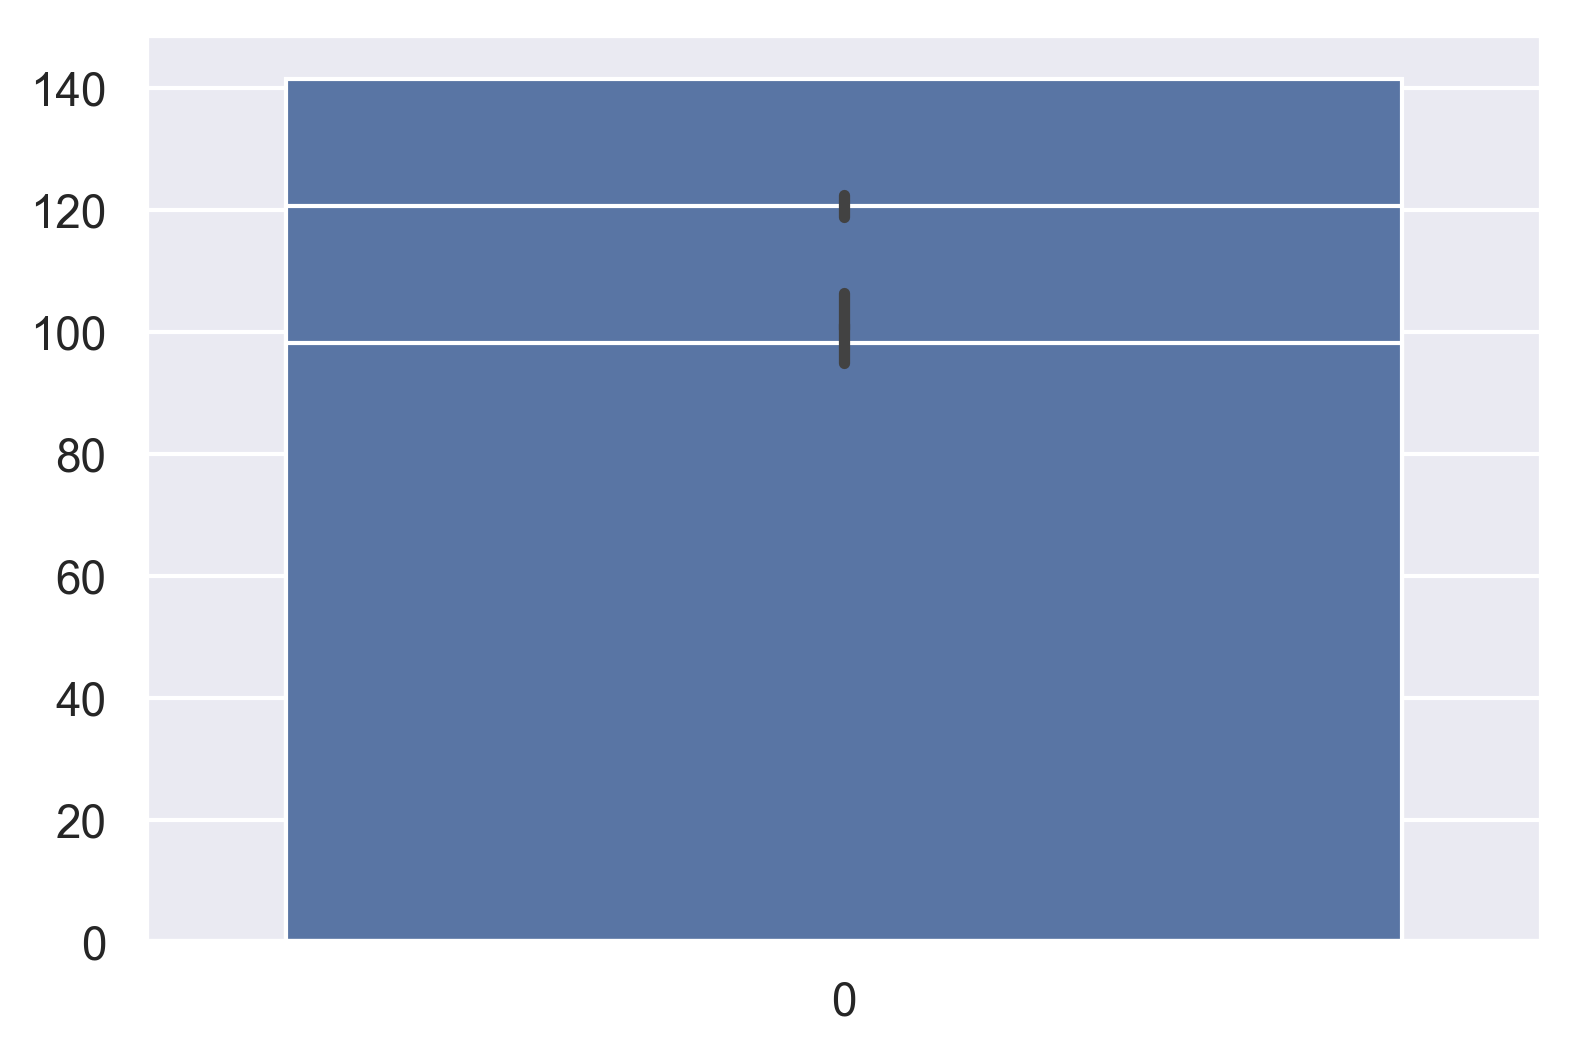

In [61]:
import seaborn as sns

new_data = (data.iloc[-1] * 100) / data.iloc[0]

for i in range(K):
    tickers = data.columns[kmeans.labels_ == i]
    profit = new_data[tickers]
    print(profit)
    sns.barplot(data=profit)



In [24]:
corr_df["Mean"] = corr_df.mean(axis=0)
corr_df = corr_df.sort_values(by=['Mean'])
# corr_df = corr_df.drop(columns=['Mean'])
pd.DataFrame(corr_df.index)

NameError: name 'corr_df' is not defined

In [ ]:
thresholds = [-0.5, 0, 0.5]
a = list(corr_df.where(corr_df < thresholds[0]).stack().index)
b = list(corr_df.where((thresholds[0] <= corr_df) &  (corr_df < thresholds[1])).stack().index)
c = list(corr_df.where((thresholds[1] <= corr_df) &  (corr_df < thresholds[2])).stack().index)
d = list(corr_df.where((thresholds[2] <= corr_df ) & (corr_df  < 1)).stack().index)
d



In [ ]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

sse = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(corr_df)
    sse.append(kmeans.inertia_)
plt.plot(range(2, 15), sse)
# plt.show()
plt.savefig("2.png")


In [ ]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters).fit(corr_df)
centroids = kmeans.cluster_centers_
X = corr_df.to_numpy()
colors = ['purple', 'blue', 'green', 'orange', 'red']
# plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap =colors)
#
# plt.show()

ax = sns.scatterplot(X[:, 0], X[:, 1], hue=kmeans.labels_, palette=colors, alpha=0.5, s=7)
ax = sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                     hue=range(num_clusters), palette=colors, s=20, legend=False, ax=ax)
plt.show()

In [ ]:
Company = pd.DataFrame(corr_df.index)
cluster_labels = pd.DataFrame(kmeans.labels_)
df = pd.concat([Company, cluster_labels],axis = 1)
df['color'] = [colors[label] for label in kmeans.labels_]
df